In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.chdir('..')

import pickle
import re
from pathlib import Path

import torch
import datasets
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from transformers.modeling_outputs import CausalLMOutputWithPast

from tqdm import tqdm

from model import MemoryCell

In [2]:
pd.set_option('display.max_rows', 200)

In [3]:
import pandas as pd
texts_df = pd.read_csv('./data/pg19_valid_1k_chunks.csv', index_col=0)
texts_df.head()

,text
0,"'Let us stay here,' she exclaimed. 'The one ro..."
1,These lobsters don't realize that Jonesy's fas...
2,It certainly was not relief that he felt on di...
3,Down to 1765 the duty imposed was only one pen...
4,"And what was, perhaps, more extraordinary, tho..."


In [4]:
import json
tokens_to_bytes = json.load(open('./data/tokens_to_bytes.json', 'r'))

In [5]:
models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
          'EleutherAI/pythia-2.8b',
          'allenai/OLMo-1B-0724-hf',
          'princeton-nlp/Sheared-LLaMA-1.3B',
          'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B',
         ]
N_mem_tokens = 1

data = []
from pathlib import Path
for model_name in tqdm(models):
    cfg = AutoConfig.from_pretrained(model_name)
    getattr(cfg, 'num_hidden_layers')
    load_path = Path(f'./runs/{model_name}/')
    for file_path in load_path.glob(f'mem_{N_mem_tokens}_len_*.pkl'):
        if file_path.is_file():
            # Extract max_length from the file name using regex
            match = re.search(f'mem_{N_mem_tokens}_len_(\d+)(_rnd_vocab_100k)?\.pkl', file_path.name)
            if match:
                max_length = int(match.group(1))
            else:
                continue
            
            try:
                with open(file_path, 'rb') as f:
                    d = pickle.load(f)
            except Exception as e:
                continue

        try:
            d = pickle.load(open(file_path, 'rb'))
        except:
            continue
        for el in d:
            data += [{
                'model_name': model_name,
                'max_length': el['max_length'],
                'n_mem_tokens': el['n_mem_tokens'],
                'original_loss': el['original_loss'],
                'best_loss': np.min(el['losses'][:5000]),#el['best_loss'],
                'best_accuracy': np.max(el['accuracies'][:5000]),#el['best_accuracy'],#np.max(el['accuracies'][:5000]), #
                'shuffled': el['args'].get('shuffled', False),
                'mem_dim': el['best_memory_params'].shape[-1],
                'n_layers': getattr(cfg, 'num_hidden_layers'),
                'vocab_size': getattr(cfg, 'vocab_size'),
                'n_att_heads': getattr(cfg, 'num_attention_heads'),
                'intermediate_size': getattr(cfg, 'intermediate_size'),
                'token2bytes': tokens_to_bytes.get(model_name)
            }]
all_models_df = pd.DataFrame(data)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:22<00:00,  2.47s/it]


In [ ]:
n_mem_tokens = 1
all_models_non_rnd_df = all_models_df[(all_models_df['shuffled'] == False)&(all_models_df['n_mem_tokens'] == n_mem_tokens)]
all_models_non_rnd_df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads,intermediate_size,token2bytes
0,EleutherAI/pythia-160m,8,1,4.882830,0.261007,1.000000,False,768,12,50304,12,3072,0.231407
1,EleutherAI/pythia-160m,8,1,6.018319,0.304136,1.000000,False,768,12,50304,12,3072,0.231407
2,EleutherAI/pythia-160m,8,1,3.802093,0.751129,1.000000,False,768,12,50304,12,3072,0.231407
3,EleutherAI/pythia-160m,8,1,4.751411,0.964425,1.000000,False,768,12,50304,12,3072,0.231407
4,EleutherAI/pythia-160m,8,1,5.125309,0.491976,1.000000,False,768,12,50304,12,3072,0.231407
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5645,meta-llama/Meta-Llama-3.1-8B,2560,1,2.811077,1.237334,0.731536,False,4096,32,128256,32,14336,0.229209
5646,meta-llama/Meta-Llama-3.1-8B,2560,1,2.499291,0.331149,0.951934,False,4096,32,128256,32,14336,0.229209
5647,meta-llama/Meta-Llama-3.1-8B,2560,1,2.331630,0.250187,0.964830,False,4096,32,128256,32,14336,0.229209
5648,meta-llama/Meta-Llama-3.1-8B,2560,1,1.989098,0.093757,0.991403,False,4096,32,128256,32,14336,0.229209


In [ ]:
df = all_models_non_rnd_df[['model_name', 'max_length', 'best_accuracy']]
df

,model_name,max_length,best_accuracy
0,EleutherAI/pythia-160m,8,1.000000
1,EleutherAI/pythia-160m,8,1.000000
2,EleutherAI/pythia-160m,8,1.000000
3,EleutherAI/pythia-160m,8,1.000000
4,EleutherAI/pythia-160m,8,1.000000
...,...,...,...
5645,meta-llama/Meta-Llama-3.1-8B,2560,0.731536
5646,meta-llama/Meta-Llama-3.1-8B,2560,0.951934
5647,meta-llama/Meta-Llama-3.1-8B,2560,0.964830
5648,meta-llama/Meta-Llama-3.1-8B,2560,0.991403


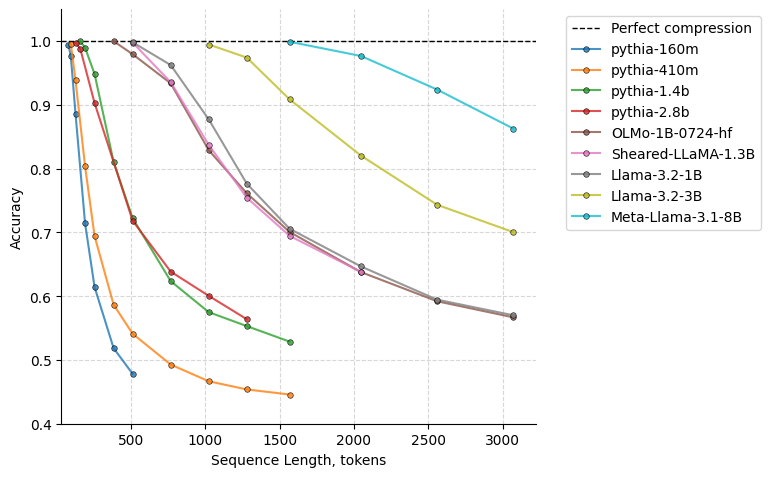

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Suppose df has columns: ['model_name', 'max_length', 'best_accuracy']

unique_models = df['model_name'].unique()

# Color palette (one color per model)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_models)))

fig, ax = plt.subplots(figsize=(8, 5))

for i, model in enumerate(unique_models):
    # Filter rows for this model
    sub = df[df['model_name'] == model].copy()
    
    # Group by max_length, compute mean & std
    grouped = (
        sub.groupby('max_length')['best_accuracy']
           .agg(['mean', 'std'])
           .reset_index()
           .sort_values('max_length')
    )

    x_vals = grouped['max_length'].values
    y_mean = grouped['mean'].values
    y_std  = grouped['std'].values

    # start from point with max length and best accuracy
    st_index = max(np.where(y_mean.max() * 0.99 <= y_mean)[0].max(), 0)
    x_vals, y_mean, y_std = x_vals[st_index:], y_mean[st_index:], y_std[st_index:]

    # Plot the mean line in the model’s color, but make whiskers black
    ax.errorbar(
        x_vals,
        y_mean,
        # yerr=y_std,
        color=colors[i],       # line color
        ecolor='black',        # error bar (whiskers) color
        elinewidth=0.8,          # thinner error bar lines
        capsize=2,             # small horizontal caps
        marker='o',            # circle marker
        markevery=1,
        errorevery=(i % 2, 2),
        markersize=4,          # slightly smaller markers
        markeredgecolor='black',
        markeredgewidth=0.5,   # subtle outline on markers
        linewidth=1.5,
        alpha=0.8,
        label=model.split('/', 1)[-1]
    )

ax.axhline(y=1.0, color='black', linestyle='--', linewidth=1, label='Perfect compression')

ax.set_xlabel("Sequence Length, tokens")
ax.set_ylabel("Accuracy")

# ax.set_xscale('log')
ax.set_ylim((0.4, 1.05))
ax.set_xlim((32, 3224))

# Move legend outside plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Clean spines, dashed grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='both', which='major', linestyle='--', alpha=0.5)

import matplotlib as mpl
mpl.rcParams['font.size'] = 14           # Base font size
mpl.rcParams['axes.labelsize'] = 14      # Axis label font size
mpl.rcParams['axes.titlesize'] = 14      # Title font size
mpl.rcParams['xtick.labelsize'] = 12     # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 12     # Y-axis tick label font size
mpl.rcParams['legend.fontsize'] = 12     # Legend font size

plt.tight_layout()
plt.show()